In [2]:
from BCBio import GFF
from Bio import SeqIO
import os
import subprocess
from BCBio.GFF import GFFExaminer

def sort_exons_and_check_invariant(exons):
  assert(len(exons)>0) # you never know lol, esp cuz pairagon is so scuffed
  exons.sort()
  for i in range(len(exons)):
    assert (exons[i][0]<=exons[i][1])
    assert(i==len(exons)-1 or exons[i][1]<exons[i+1][0])
    
"""
Returns exon array, 0-indexed (coords are in reference to the reference genome), and sorted in ascending order (even if reference strand is template strand rather than coding strand)
"""
def extract_exons_from_gmap_file(gmap_file_path):
  exons = [] # 0-indexed coords, both inclusive
  reverse:bool|None = None
  with open(gmap_file_path) as gmap_file:
    recs = []
    for rec in GFF.parse(gmap_file): # wait I really don't know if this is right or not also do we really need the sequence itself is the real question
      recs.append(rec)
      assert(len(recs)==1), recs # surely ...
    for match in rec.features:
      assert (match.type == "cDNA_match")
      exons.append([int(match.location.start),match.location.end-1])
      reverse = bool(match.location.strand==-1)

  sort_exons_and_check_invariant(exons)
  assert( reverse is not None)
  return exons,reverse

def extract_exons_from_ans(ans_file_path):
  lines = [line for line in open(ans_file_path)]
  assert(lines), [ans_file_path, lines]
  is_reversed = lines.pop()=='-'
  exons = []
  for line in lines:
    start,end = line.split("/")
    exons.append([int(start)-1,int(end)-1])
  sort_exons_and_check_invariant(exons)
  return exons, is_reversed

def extract_exons_from_pairagon_file(pairagon_gtf_path):
  # print(pairagon_gtf_path)
  is_reversed = None
  exons = []
    
  with open(pairagon_gtf_path) as gtf_file:
    for line in gtf_file: #ya know what screw BioPython
      row_data = line.split("\t") 
      is_reversed = row_data[6]=='-'
      start,end = int(row_data[3]),int(row_data[4]) # already 0-indexed because pairagon is pairagon
      exons.append([start,end])
    sort_exons_and_check_invariant(exons)
  assert(is_reversed is not None)
  return exons,is_reversed

def score_on_nucleotide_lvl(true_exons:list[tuple[int,int]],true_reversed:bool,found_exons:list[tuple[int,int]],found_reversed:bool):
  if true_reversed != found_reversed:
    return 0, 0 # There's no hope lol
  assert(len(true_exons)>=1 and len(found_exons)>=1)
  startNucleotide = min(true_exons[0][0],found_exons[0][0])
  endNucleotide = max(true_exons[-1][1],found_exons[-1][1])
  
  i = j = 0 # what exon interval we're currently looking at
  
  false_positives = false_negatives = true_positives = 0 # true negatives apparently don't matter
  for pos in range(startNucleotide,endNucleotide+1):
    while(i<len(true_exons)and true_exons[i][1]<pos):
      i+=1
    while j<len(found_exons) and found_exons[j][1]<pos:
      j+=1
    
    is_true_exon = i!=len(true_exons) and pos>=true_exons[i][0]
    is_found_exon = j!=len(found_exons) and pos >= found_exons[j][0]
    # print(pos,is_true_exon,is_found_exon)
    if is_true_exon:
      if is_found_exon:
        true_positives+=1
      else:
        false_negatives+=1
    else:
      if is_found_exon:
        false_positives+=1
  sensitivity = true_positives/(true_positives+false_negatives) 
  specificity = true_positives/(true_positives+false_positives)
  # print(sensitivity,accuracy)
  return sensitivity,specificity

    
# Assumes that exon lists are sorted and disjoint 
# move tru exon pointer forwards until true end is after current start
# after attempted match, move true exon ptr until true start is > cur end (not needed)
def score_on_exon_lvl(true_exons:list[tuple[int,int]],true_reversed:bool,found_exons:list[tuple[int,int]],found_reversed:bool):
  if true_reversed != found_reversed: # I mean okay if you messed this up you actually kinda suck
    return 0, 0
  true_i = 0
  false_positives = false_negatives = true_positives = 0
  for [start,end] in found_exons:
    while true_i<len(true_exons) and true_exons[true_i][1]<start:
      true_i+=1
      false_negatives+=1 # we just never matched this true exon :(
    if true_i<len(true_exons) and true_exons[true_i] == [start,end]:
      true_positives+=1
      true_i+=1
    else:
      false_positives+=1 # found exon is wrong lol
  false_negatives+=len(true_exons)-true_i # everything that we didn't get to
  sensitivity = true_positives/(true_positives+false_negatives) 
  specificity = true_positives/(true_positives+false_positives)
  # print(sensitivity,accuracy)
  return sensitivity,specificity
def HM(x,y):
  if x == 0 or y == 0:
    return 0
  return 1/((1/x+1/y)/2)



In [3]:
# Ignore this code block / don't change it (caching it here for later)
#! path/to/venv/bin/python3
# no joke I actually called the path this lol (yeah I'm lazy)
from BCBio import GFF
from Bio import SeqIO
import os
import subprocess
from BCBio.GFF import GFFExaminer


def get_scores(test_path):
  transcript_to_score_map = {}
  # read in files 
  for path,_,files in os.walk(test_path):
    if path == f"{test_path}":
      continue
    # print(path,files)
    transcript_id = path.replace(f"./{test_path}/","")
    assert ("gmap.gff" in files) # GMAP is op (100% coverage)
    # print(path,files)
    if "pairagon_seeded.gtf" not in files:
      print("missing!",path)
      continue
    # if "pairagonE_seeded.gtf" not in files:
    #   print("E thing missing!",path)
    #   continue


    # Just temp code to transfer pairagon alignments to non-corrupt .gtf format
    # subprocess.run(f"alignmentConvert.pl -i {path}/pairagon.pair -o gtf -q {path}/cdna.fa -t {path}/genome.fa > {path}/pairagon.gtf",check=True,shell=True)

    # print(transcript_id)
    # seq_dict = SeqIO.to_dict(SeqIO.parse(f"{path}/genome.fa", "fasta")) 
    id = path.split("/")[1]
    # orientation 
    gmap_exons, gmap_is_reversed = extract_exons_from_gmap_file(f"{'test_stricter_human_genome_with_2_nt_ext'}/{id}/gmap.gff")
    pairagon_exons, pairagon_is_reversed = extract_exons_from_pairagon_file(f"{'test_stricter_human_genome_with_1_nt_ext'}/{id}/pairagon_seeded.gtf")
    true_exons_1,true_is_reversed_1 = extract_exons_from_ans(f"{'test_stricter_human_genome_with_1_nt_ext'}/{id}/ans.txt")
    true_exons_2,true_is_reversed_2 = extract_exons_from_ans(f"{'test_stricter_human_genome_with_2_nt_ext'}/{id}/ans.txt")
    
    
    # print(gmap_is_reversed,gmap_exons)
    # print(pairagon_is_reversed,pairagon_exons)
    # print(true_is_reversed,true_exons)

    # print(score_on_exon_lvl([[1,1],[2,2],[3,9],[10,12]],False,[[1,1],[2,2],[3,3],[4,4],[10,12]],False)) # type: ignore
    gmap_exon_score_se,gmap_exon_score_sp = score_on_exon_lvl(true_exons_2,true_is_reversed_2,gmap_exons,gmap_is_reversed)
    pairagon_exon_score_se,pairagon_exon_score_sp = score_on_exon_lvl(true_exons_1,true_is_reversed_1,pairagon_exons,pairagon_is_reversed)

    gmap_nucleotide_score_se,gmap_nucleotide_score_sp = score_on_nucleotide_lvl(true_exons_2,true_is_reversed_2,gmap_exons,gmap_is_reversed)
    pairagon_nucleotide_score_se,pairagon_nucleotide_score_sp = score_on_nucleotide_lvl(true_exons_1,true_is_reversed_1,pairagon_exons,pairagon_is_reversed)
    transcript_to_score_map[transcript_id] = {
      "gmap_exon":HM(gmap_exon_score_sp,gmap_exon_score_se),
      "gmap_nucleotide":HM(gmap_nucleotide_score_se,gmap_nucleotide_score_sp),
      "pairagon_exon":HM(pairagon_exon_score_sp,pairagon_exon_score_se),
      "pairagon_nucleotide":HM(pairagon_nucleotide_score_sp,pairagon_nucleotide_score_se),
      "gmap_exon_score_se":gmap_exon_score_se,
      "gmap_exon_score_sp":gmap_exon_score_sp,
      "pairagon_exon_score_se":pairagon_exon_score_se,
      "pairagon_exon_score_sp":pairagon_exon_score_sp,
      "gmap_nucleotide_score_se":gmap_nucleotide_score_se,
      "gmap_nucleotide_score_sp":gmap_nucleotide_score_sp,
      "pairagon_nucleotide_score_se":pairagon_nucleotide_score_se,
      "pairagon_nucleotide_score_sp":pairagon_nucleotide_score_sp
    }
    # print(transcript_id,gmap_exon_score,gmap_nucleotide_score,pairagon_exon_score,pairagon_nucleotide_score)
  
  return transcript_to_score_map
    # print(gmap_exons,gmap_is_reverse)
  # convert everything over to exon segments 
transcript_to_score_map = get_scores("./derek/simulatedmRNAs")
print("SIZE",len(transcript_to_score_map))

FileNotFoundError: [Errno 2] No such file or directory: 'test_stricter_human_genome_with_2_nt_ext/derek/gmap.gff'

In [4]:
#! path/to/venv/bin/python3
# no joke I actually called the path this lol (yeah I'm lazy)
from BCBio import GFF
from Bio import SeqIO
import os
import subprocess
from BCBio.GFF import GFFExaminer


def get_scores(test_path):

  transcript_to_score_map = {}
  # read in files 
  for path,_,files in os.walk(test_path):
    if path == f"{test_path}":
      continue
    # print(path,files)
    transcript_id = path.replace(f"./{test_path}/","")
    assert ("gmap.gff" in files), files # GMAP is op (100% coverage)
    # print(path,files)
    if "pairagon_seeded.gtf" not in files:
      print("missing!",path)
      continue


    # Just temp code to transfer pairagon alignments to non-corrupt .gtf format
    # subprocess.run(f"alignmentConvert.pl -i {path}/pairagon.pair -o gtf -q {path}/cdna.fa -t {path}/genome.fa > {path}/pairagon.gtf",check=True,shell=True)

    # print(transcript_id)
    # seq_dict = SeqIO.to_dict(SeqIO.parse(f"{path}/genome.fa", "fasta")) 

    # orientation 
    gmap_exons, gmap_is_reversed = extract_exons_from_gmap_file(f"{path}/gmap.gff")
    pairagon_exons, pairagon_is_reversed = extract_exons_from_pairagon_file(f"{path}/pairagon_seeded.gtf")
    true_exons,true_is_reversed = extract_exons_from_ans(f"{path}/ans.txt")
    
    
    # print(gmap_is_reversed,gmap_exons)
    # print(pairagon_is_reversed,pairagon_exons)
    # print(true_is_reversed,true_exons)

    # print(score_on_exon_lvl([[1,1],[2,2],[3,9],[10,12]],False,[[1,1],[2,2],[3,3],[4,4],[10,12]],False)) # type: ignore
    gmap_exon_score_se,gmap_exon_score_sp = score_on_exon_lvl(true_exons,true_is_reversed,gmap_exons,gmap_is_reversed)
    pairagon_exon_score_se,pairagon_exon_score_sp = score_on_exon_lvl(true_exons,true_is_reversed,pairagon_exons,pairagon_is_reversed)

    gmap_nucleotide_score_se,gmap_nucleotide_score_sp = score_on_nucleotide_lvl(true_exons,true_is_reversed,gmap_exons,gmap_is_reversed)
    pairagon_nucleotide_score_se,pairagon_nucleotide_score_sp = score_on_nucleotide_lvl(true_exons,true_is_reversed,pairagon_exons,pairagon_is_reversed)
    transcript_to_score_map[transcript_id] = {
      "gmap_exon":HM(gmap_exon_score_sp,gmap_exon_score_se),
      "gmap_nucleotide":HM(gmap_nucleotide_score_se,gmap_nucleotide_score_sp),
      "pairagon_exon":HM(pairagon_exon_score_sp,pairagon_exon_score_se),
      "pairagon_nucleotide":HM(pairagon_nucleotide_score_sp,pairagon_nucleotide_score_se),
      "gmap_exon_score_se":gmap_exon_score_se,
      "gmap_exon_score_sp":gmap_exon_score_sp,
      "pairagon_exon_score_se":pairagon_exon_score_se,
      "pairagon_exon_score_sp":pairagon_exon_score_sp,
      "gmap_nucleotide_score_se":gmap_nucleotide_score_se,
      "gmap_nucleotide_score_sp":gmap_nucleotide_score_sp,
      "pairagon_nucleotide_score_se":pairagon_nucleotide_score_se,
      "pairagon_nucleotide_score_sp":pairagon_nucleotide_score_sp
    }
    # print(transcript_id,gmap_exon_score,gmap_nucleotide_score,pairagon_exon_score,pairagon_nucleotide_score)
  
  return transcript_to_score_map
    # print(gmap_exons,gmap_is_reverse)
  # convert everything over to exon segments 
transcript_to_score_map = get_scores("./derek/simulatedmRNAs")

print("SIZE",len(transcript_to_score_map))

SIZE 56


In [43]:
def get_exon_dist(test_path):
  exon_cnts = []
  exon_lengths = []
  reversed = [0,0]
  for path,_,files in os.walk(test_path):
    if path == test_path:
      continue
    if "pairagon_seeded.gtf" not in files:
      continue
    assert "ans.txt" in files
    
    true_exons,is_reversed = extract_exons_from_ans(f"{path}/ans.txt")
    exon_cnts.append(len(true_exons))
    exon_lengths.extend([e-s+1 for s,e in true_exons])
    reversed[is_reversed]+=1
  return exon_cnts,exon_lengths,reversed

exon_counts,exon_lengths,reversed_transcript_stats = get_exon_dist("./derek/mutatedRNAs-0.05/")

In [6]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import seaborn.objects as so


In [26]:
# import shutil
# cnt = 0
# for path,scores in transcript_to_score_map.items():
#   id = path.split("/")[1]
#   if scores["pairagon_exon"] == 1:
    
#     shutil.copytree(path, f"mini_test/{id}")

#     print(path,scores["pairagon_exon"])
#     cnt+=1
#     if cnt==30:
#       break

In [9]:
import scipy.stats as stats 

import statistics


TtestResult(statistic=7.769910117878295, pvalue=7.610819082471139e-11, df=64.81279378483428)
TtestResult(statistic=2.6995295506243195, pvalue=0.00821033941440028, df=95.72103101665462)


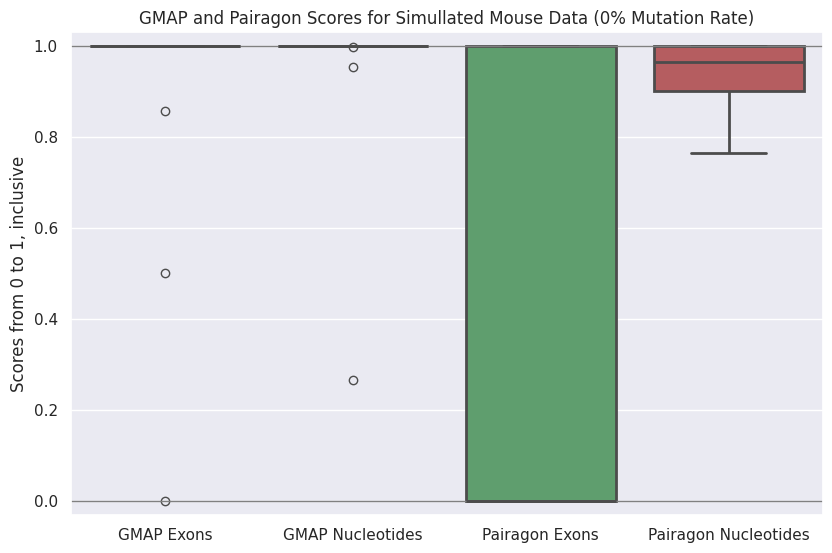

In [10]:


sns.set_theme(rc={'figure.figsize':(9.7,6.27)})

# for transcript in transcript_to_score_map.items():
#     print(transcript[0])
#     print(transcript[1])

gmap_exons = [entry["gmap_exon"] for entry in transcript_to_score_map.values()]
gmap_nucleotides = [entry["gmap_nucleotide"] for entry in transcript_to_score_map.values()]
pairagon_exons = [entry["pairagon_exon"] for entry in transcript_to_score_map.values()]
pairagon_nucleotides = [entry["pairagon_nucleotide"] for entry in transcript_to_score_map.values()]
data = pd.DataFrame({"GMAP Exons":gmap_exons,"GMAP Nucleotides":gmap_nucleotides,"Pairagon Exons":pairagon_exons,"Pairagon Nucleotides":pairagon_nucleotides})
data.reset_index()
# print(data)
print(stats.ttest_ind(data["GMAP Exons"], data["Pairagon Exons"], equal_var = False)) 
print(stats.ttest_ind(data["GMAP Nucleotides"], data["Pairagon Nucleotides"], equal_var = False)) 
# print("GE",statistics.mean(data["GMAP Exons"]))
# print("PE",statistics.mean(data["Pairagon Exons"]))
# print("GN",statistics.mean(data["GMAP Nucleotides"]))
# print("PN",statistics.mean(data["Pairagon Nucleotides"]))
sns.boxplot(data=data,linewidth=2).set(title="GMAP and Pairagon Scores for Simullated Mouse Data (0% Mutation Rate)")
plt.ylim(-.03,1.03)
plt.ylabel("Scores from 0 to 1, inclusive")
plt.axhline(y=0, color='gray', linewidth=1)
plt.axhline(y=1, color='gray', linewidth=1)

# sns.displot(data=data["GMAP Exons"]).set(title="Scoring distributions")
# sns.displot(data=data["GMAP Nucleotides"]).set(title="Scoring distributions")
# sns.displot(data=data["Pairagon Exons"]).set(title="Scoring distributions")
# sns.displot(data=data["Pairagon Nucleotides"]).set(title="Scoring distributions")
# print(condensed)


0.9852578118535256 0.9974901701190462
TtestResult(statistic=-0.9283039706513986, pvalue=0.3572918309110704, df=55.19523087451589)
0.9868977176669484 0.9015803931790617
TtestResult(statistic=4.318542022186793, pvalue=3.4890816446360456e-05, df=108.43021503989068)


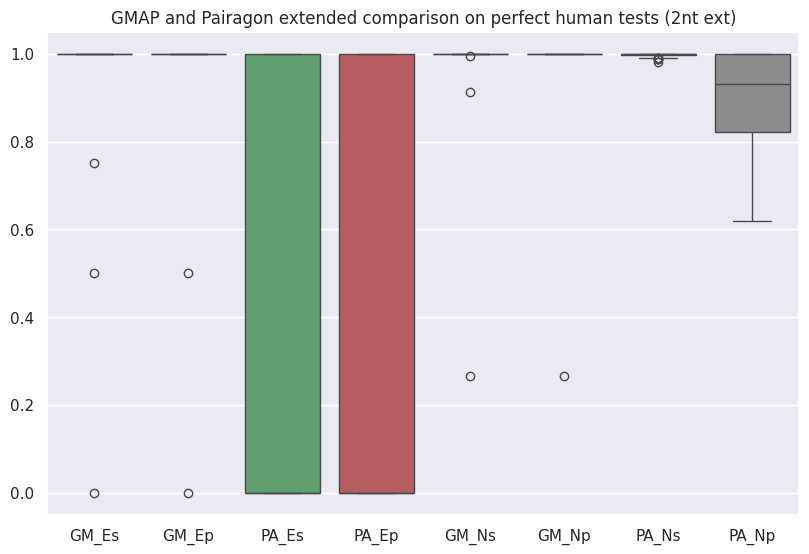

In [13]:
def get_list_from_key(key_name):
  return [entry[key_name] for entry in transcript_to_score_map.values()]
data = {
  "GM_Es": get_list_from_key("gmap_exon_score_se"),
 "GM_Ep": get_list_from_key("gmap_exon_score_sp"),
 "PA_Es": get_list_from_key("pairagon_exon_score_se"),
 "PA_Ep": get_list_from_key("pairagon_exon_score_sp"),
 "GM_Ns": get_list_from_key("gmap_nucleotide_score_se"),
 "GM_Np": get_list_from_key("gmap_nucleotide_score_sp"),
 "PA_Ns": get_list_from_key("pairagon_nucleotide_score_se"),
 "PA_Np": get_list_from_key("pairagon_nucleotide_score_sp")}
sns.boxplot(data=data,linewidth=1).set(title="GMAP and Pairagon extended comparison on perfect human tests (2nt ext)")
print(statistics.mean(data["GM_Ns"]),statistics.mean(data["PA_Ns"]))
print(stats.ttest_ind(data["GM_Ns"], data["PA_Ns"], equal_var = False)) # 0.0007865656938897028
print(statistics.mean(data["GM_Np"]),statistics.mean(data["PA_Np"]))

print(stats.ttest_ind(data["GM_Np"], data["PA_Np"], equal_var = False))  # 0.2281113091396606


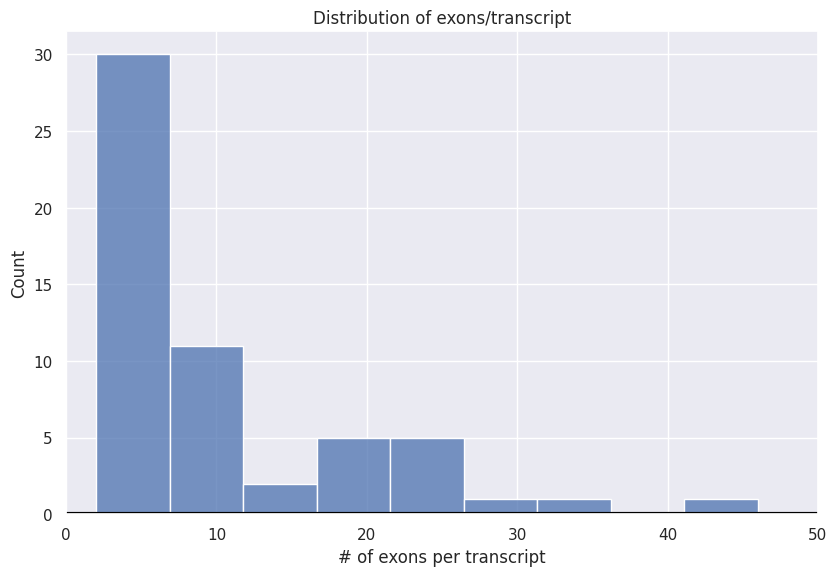

In [30]:
sns.histplot(data={"# of exons per transcript":exon_counts}, x = "# of exons per transcript").set_title("Distribution of exons/transcript")
plt.xlim(0, 50)
plt.axhline(y=0, color='black', linewidth=3)


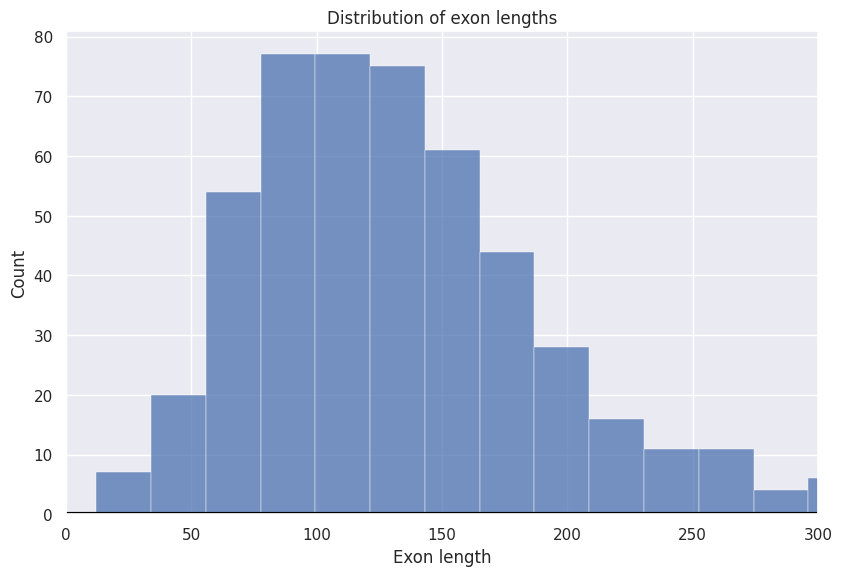

In [31]:
sns.histplot(data={"Exon length":exon_lengths}, x = "Exon length").set_title("Distribution of exon lengths")
plt.xlim(0, 300)
# plt.axvline(x=0, color='black', linewidth=3)
plt.axhline(y=0, color='black', linewidth=3)
plt.show()

f 0.16666666666666666
[[1157, 1188], [2625, 2745], [8106, 8381], [12652, 13011], [13779, 13842]]
[[1157, 1231], [2578, 2747], [8097, 8383], [12640, 13010], [13569, 13569], [13779, 13842]]
(0.9988276670574443, 0.8801652892561983)
./derek/simulatedmRNAs/ENSMUST00000206687.2

f 0.0
[[337, 394], [1641, 2493]]
[[337, 393], [1638, 2493]]
(0.9989023051591658, 0.9967141292442497)
./derek/simulatedmRNAs/ENSMUST00000221763.2

f 0.0
[[2405, 2610], [7480, 7617], [8347, 8409], [20607, 20645]]
[[2405, 2658], [7452, 7615], [8330, 8411], [20599, 20645]]
(0.9955156950672646, 0.8117001828153565)
./derek/simulatedmRNAs/ENSMUST00000106964.8

f 0.0
[[777, 865], [13560, 13712]]
[[777, 867], [13519, 13712]]
(1.0, 0.8491228070175438)
./derek/simulatedmRNAs/ENSMUST00000207628.2

f 0.0
[[973, 1009], [2649, 2864], [3206, 3447], [5412, 5582], [5858, 5869], [6321, 6432], [7420, 7529], [11026, 11139], [13701, 13712], [13944, 13995], [14182, 14252], [18483, 18569], [23588, 23726], [26298, 26365], [26460, 26595], [26

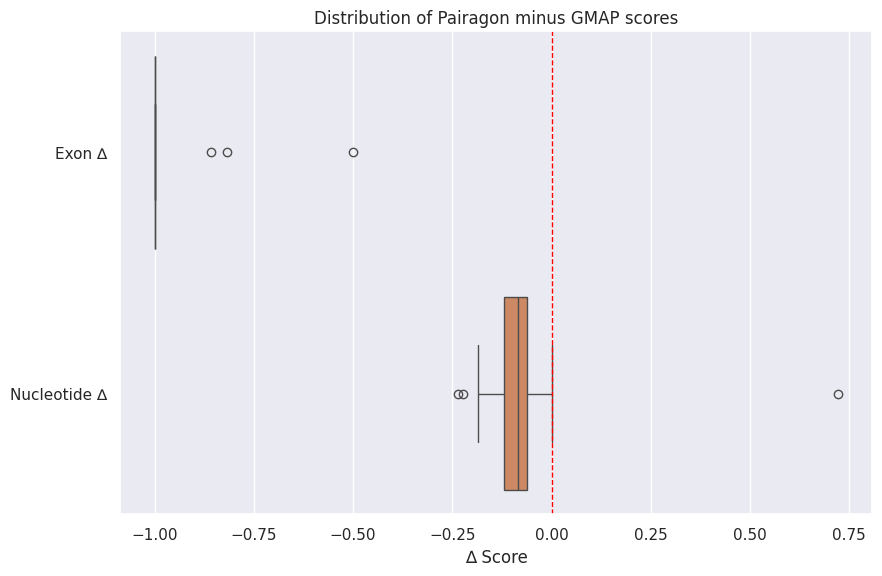

In [12]:

def score(a,b):
  if a==b:
    if a!=1:
      print(a)
    return 0
  return 1 if a>b else 2
nucleotide_sens = [0,0,0]
nucleotide_spec = [0,0,0]
nucleotide_score = [0,0,0]
e_correct = 0
general_scores_exon = []
general_scores_nuc = []
for path,scores in transcript_to_score_map.items():
  nucleotide_sens[score(scores["gmap_nucleotide_score_se"],scores["pairagon_nucleotide_score_se"])]+=1
  nucleotide_spec[score(scores["gmap_nucleotide_score_sp"],scores["pairagon_nucleotide_score_sp"])]+=1
  nucleotide_score[score(scores["gmap_nucleotide"],scores["pairagon_nucleotide"])]+=1
  

  # nucleotide_sens[score(scores["gmap_exon_score_se"],scores["pairagon_exon_score_se"])]+=1
  # nucleotide_spec[score(scores["gmap_exon_score_sp"],scores["pairagon_exon_score_sp"])]+=1
  # nucleotide_score[score(scores["gmap_exon"],scores["pairagon_exon"])]+=1
  general_scores_exon.append(scores["pairagon_exon"]-scores["gmap_exon"])
  general_scores_nuc.append(scores["pairagon_nucleotide"]-scores["gmap_nucleotide"])
  p_exons,_ = extract_exons_from_gmap_file(f"{path}/gmap.gff")
  e_exons,_ = extract_exons_from_pairagon_file(f"{path}/pairagon_seeded.gtf")
  true_exons,_ = extract_exons_from_ans(f"{path}/ans.txt")
  e_correct+=true_exons==p_exons
  
  if scores["pairagon_exon_score_sp"] != 1:
    print("f",scores["pairagon_exon_score_sp"])
    print(true_exons)
    print(e_exons)
    print(score_on_nucleotide_lvl(true_exons,False,e_exons,False))
  # for i in range(max(len(p_exons),len(e_exons))):

  #   if i>=len(p_exons) or i>= len(e_exons):
  #     print(true_exons[i] if i < len(true_exons) else "GONE",p_exons[i] if i < len(p_exons) else "GONE",e_exons[i] if i < len(e_exons) else "GONE")
      
  #   elif p_exons[i]!=e_exons[i]:
  #     print(true_exons[i][0]-p_exons[i][0],-(true_exons[i][1]-p_exons[i][1]),true_exons[i][0]-e_exons[i][0],-(true_exons[i][1]-e_exons[i][1]))
  #     # print(true_exons[i] if i < len(true_exons) else "GONE",p_exons[i] if i < len(p_exons) else "GONE",e_exons[i] if i < len(e_exons) else "GONE")

  if p_exons != e_exons:
    print(path)
    
    print()
# for id,scores in transcript_to_score_map.items():
print(nucleotide_sens,nucleotide_spec,nucleotide_score)
print(e_correct/len(transcript_to_score_map))

general_scores_nuc = [score for score in general_scores_nuc if score != 0]
general_scores_exon = [score for score in general_scores_exon if score != 0]

sns.boxplot(data={"Exon ∆":general_scores_exon,"Nucleotide ∆":general_scores_nuc},orient='h')
plt.title("Distribution of Pairagon minus GMAP scores")

# Add x-axis label
plt.xlabel("∆ Score")
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)

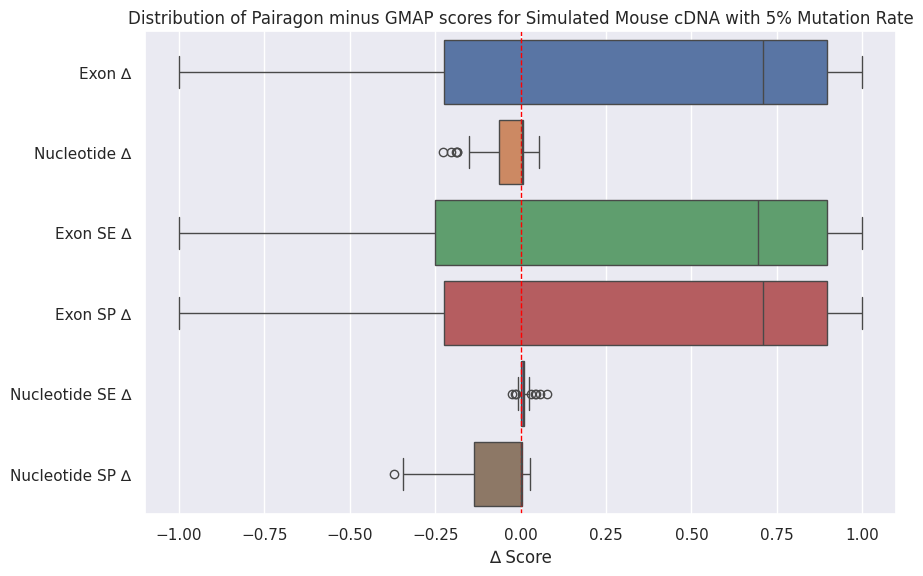

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt

general_scores_exon = []
general_scores_nuc = []
general_scores_exon_se = []
general_scores_exon_sp = []
general_scores_nuc_se = []
general_scores_nuc_sp = []

for path, scores in transcript_to_score_map.items():
    general_scores_exon.append(scores["pairagon_exon"] - scores["gmap_exon"])
    general_scores_nuc.append(scores["pairagon_nucleotide"] - scores["gmap_nucleotide"])
    general_scores_exon_se.append(scores["pairagon_exon_score_se"] - scores["gmap_exon_score_se"])
    general_scores_exon_sp.append(scores["pairagon_exon_score_sp"] - scores["gmap_exon_score_sp"])
    general_scores_nuc_se.append(scores["pairagon_nucleotide_score_se"] - scores["gmap_nucleotide_score_se"])
    general_scores_nuc_sp.append(scores["pairagon_nucleotide_score_sp"] - scores["gmap_nucleotide_score_sp"])

# Remove zero values from the lists
general_scores_nuc = [score for score in general_scores_nuc if score != 0]
general_scores_exon = [score for score in general_scores_exon if score != 0]
general_scores_exon_se = [score for score in general_scores_exon_se if score != 0]
general_scores_exon_sp = [score for score in general_scores_exon_sp if score != 0]
general_scores_nuc_se = [score for score in general_scores_nuc_se if score != 0]
general_scores_nuc_sp = [score for score in general_scores_nuc_sp if score != 0]

data = {
    "Exon ∆": general_scores_exon,
    "Nucleotide ∆": general_scores_nuc,
    "Exon SE ∆": general_scores_exon_se,
    "Exon SP ∆": general_scores_exon_sp,
    "Nucleotide SE ∆": general_scores_nuc_se,
    "Nucleotide SP ∆": general_scores_nuc_sp
}

sns.boxplot(data=data, orient='h')
plt.title("Distribution of Pairagon minus GMAP scores for Simulated Mouse cDNA with 25% Mutation Rate")
plt.xlabel("∆ Score")
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.show()
sns.set_theme()

In [ ]:
# import gffutils
# from Bio import SeqIO
# from Bio.SeqRecord import SeqRecord
# import os
# import subprocess
# annotation_file_name = "gencode.v45.basic.annotation.gff3"
# transcript_file_name = "gencode.v45.transcripts.fa"

# db = gffutils.FeatureDB('full.db', keep_order=True)
# print("Loaded in db!")
# transcript_sequences = SeqIO.parse(open(transcript_file_name),'fasta')
# transcript_id_to_sequence = {seq_record.id.split("|")[0]:seq_record.seq for seq_record in SeqIO.parse(transcript_file_name,"fasta") }
# print("Loaded in transcript sequences!")

In [ ]:
# transcript_lengths = [] # the full one
# cDNA_lengths = []
# num_exons = []
# chromosomes = {}
# for gene in db.features_of_type('gene',order_by='start'):
  
#   if gene['level'][0] != "1":
#     continue
  
#   transcript_ids = []
  
#   for transcript in db.children(gene,featuretype='transcript',order_by='start'):
#     transcript_id = transcript.id
#     if transcript.start is None or transcript.end is None:
#       continue
    
#     # if not os.path.exists(f"tests/{transcript_id}/pairagon.gtf"):
#     #   continue
#     chromosomes[transcript.seqid]=chromosomes[transcript.seqid]+1 if transcript.seqid in chromosomes else 1
#     cDNA_lengths.append(len(transcript_id_to_sequence[transcript_id]))
#     transcript_lengths.append(transcript.end-transcript.start+1) # cuz inclusive bounds
#     transcript_ids.append(transcript_id)
    
#     exon_count = 0
    
#     for exon in db.children(transcript,featuretype='exon',order_by='start'):
#       exon_count+=1
#     # if exon_count==1:
#     #   assert(False)
#     num_exons.append(exon_count)
#   # if len(transcript_ids)>=2:
#   #   print(gene.id,transcript_ids)
    
    

In [ ]:
# # print(chromosomes)


# sns.set_theme()

# modified_chromosome_data = [[x.replace("chr",""),y] for x,y in chromosomes.items()]
# modified_chromosome_data.sort(key=lambda ar:int(ar[0]) if ar[0]!='X' and ar[0] != 'Y' else 100)
# fig, ax = plt.subplots()
# # print(pd.DataFrame(modified_chromosome_data))
# # sns.barplot(data=pd.DataFrame(modified_chromosome_data),x=0,y=1).set(title="Sampled chromosome distribution",xlabel="Chromosome",ylabel="Count")
# # sns.histplot(data=transcript_lengths)
# ax.set_xlim(0,16000)
# sns.histplot(data=cDNA_lengths).set(title="cDNA lengths")

In [ ]:
# ax.set_xlim(0,max(transcript_lengths))
# sns.histplot(data=transcript_lengths).set(title="Reference genome lengths")


In [ ]:
# ax.set_xlim(0,max(num_exons))
# sns.histplot(data=num_exons).set(title="# of exons")


In [ ]:
x = 1

In [ ]:
# y = x

In [ ]:
# print(y)